# Language Classification Using Recurrent Neural Networks

In this problem the goal is to design a neural network that can correctly classify different 3 different language classes of `English`, `Hindi`, and `Mandarin`. The data are given in forms of unified '.wav' audio files and might contain silences. In order to clean the data, split the entire audio files into chunks of sequences and remove the silence, we first need to preprocess the data. Then a RNN model using Recurrent Gated Units (GRUs) is trained on the training data and a streaming step is added to evaluate the performance of the trained model on the test data.

- [Preprocessing of the Data using `librosa` package](#0)
- [Training the Model using Gated Recurrent Units (GRUs)](#1)
- [Stream and Test the Model on the Test Set](#2)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Deep Learning Colab/Language Classification - RNN/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

os.getcwd()


Your working directory was changed to /content/drive/My Drive/Deep Learning Colab/Language Classification - RNN/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


'/content/drive/My Drive/Deep Learning Colab/Language Classification - RNN'

## Import Required Libraries

In [8]:
import h5py
import numpy as np
from tensorflow.keras.layers import Input, Dense, GRU
from tensorflow.keras import Model, Sequential
import librosa, librosa.display
import os
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

## <a id="0"><u>Preprocessing of the Data using `librosa` package</u></a>

This takes each of the audio files at a time and first removes the silence from each file. For removing the silence, `librosa.effects.split` was used to find the non-silent intervals, and then only these intervals were considered to generate the features. Those intervals that were not returned were removed. Then, for each non-silent 1-D array of data loaded, `librosa.feature.mfcc` was used to generate the MFCC features of it and split it into sequences of length, which was set to 500 here. Simply put, after combining all audio files for each class, there will be `(N_seq_class, N_seqLength, N_features) = (N_seq_class, 500, 64)`. Then it generates class labels of shape `(N_seq_class, 500, 3)` for each class. The labels are set to be 1-hot arrays `[1, 0, 0]`, `[0, 1, 0]` and `[0, 0, 1]` for English, Hindi and Mandarin, respectively.

Then all these classes data are concatenated and shuffled to randomize the order of sequences. To concatenate the data, we trimmed the portion of data of each class that remained after dividing the number of total instants by 500. The last 10% of the combined data is then used as the unseen test data that was used in RNN streaming. From the rest 90%, the train-validation ratio was set to 80%-20%. After doing this, the data are saved as arrays of X_train, y_train, X_test, and y_test in `Data.hd5 `file.

In [6]:
#### generate toy data
root_dir = os.getcwd()
eng_dir = root_dir + '/train/train_english'
hin_dir = root_dir + '/train/train_hindi'
man_dir = root_dir + '/train/train_mandarin'

# define the list of languages audio files directories
lang_list = list([eng_dir, hin_dir, man_dir])

# arrays used to stack up the sequqnces for each language
x_eng = np.empty(shape=[0, 64])
x_hin = np.empty(shape=[0, 64])
x_man = np.empty(shape=[0, 64])

ii = 0
for dir_name in lang_list:
    os.chdir(dir_name)
    ii+=1
    print(ii)
    for filename in os.listdir(os.getcwd()):
        x, fs = librosa.load(filename, sr=16000)
        inter_50 = librosa.effects.split(x, top_db=50) #audio above 20dB

        x_50 = np.empty(shape=[1])

        for i in inter_50:
            start,end = i
            x_50 = np.concatenate((x_50, x[start:end]), axis=0)

        # librosa.display.waveplot(x, sr=fs)
        mfccs = librosa.feature.mfcc(y=x_50, sr=fs, n_mfcc=64, n_fft=int(fs*.025), hop_length=int(fs*.01))

        if dir_name == lang_list[0]:
            x_eng = np.concatenate((x_eng, mfccs.T), axis=0)
            # print('eng shape+= ',x_eng.shape)
        elif dir_name == lang_list[1]:
            x_hin = np.concatenate((x_hin, mfccs.T), axis=0)
            # print('hin shape+= ',x_hin.shape)
        else:
            x_man = np.concatenate((x_man, mfccs.T), axis=0)
            # print('man shape+= ',x_man.shape)




1
2
3


In [7]:
# find a portion of each class divisible by sequence length S=500 and trim the rest
S = 500
M_eng = x_eng.shape[0]
M_hin = x_hin.shape[0]
M_man = x_man.shape[0]

eng_trim_idx = np.arange(np.mod(M_eng,S))
hin_trim_idx = np.arange(np.mod(M_hin,S))
man_trim_idx = np.arange(np.mod(M_man,S))

x_eng = np.delete(x_eng, eng_trim_idx, 0)
x_hin = np.delete(x_hin, hin_trim_idx, 0)
x_man = np.delete(x_man, man_trim_idx, 0)

print(x_eng.shape)

# create labels
M_eng = x_eng.shape[0]
M_hin = x_hin.shape[0]
M_man = x_man.shape[0]

y_eng = np.ones((M_eng,1))@np.array([[1, 0, 0]])
y_hin = np.ones((M_hin,1))@np.array([[0, 1, 0]])
y_man = np.ones((M_man,1))@np.array([[0, 0, 1]])


# reshape the features and labels, e.g., (M_eng,64) to (N_eng, S, 64)
N_eng = int(M_eng/S)
N_hin = int(M_hin/S)
N_man = int(M_man/S)

X_eng = x_eng.reshape(N_eng, S, 64)
X_hin = x_hin.reshape(N_hin, S, 64)
X_man = x_man.reshape(N_man, S, 64)
Y_eng = y_eng.reshape(N_eng, S, 3)
Y_hin = y_hin.reshape(N_hin, S, 3)
Y_man = y_man.reshape(N_man, S, 3)


# Concatenate all X's and y's separately
X = np.concatenate((X_eng, X_hin, X_man), axis=0)
y = np.concatenate((Y_eng, Y_hin, Y_man), axis=0)

print(X.shape)
print(y.shape)

# Concatenate everything and shuffle
data_concat = np.concatenate((X,y), axis=2)
data_concat_shuff = shuffle(data_concat)

print(data_concat_shuff.shape)

# set the size of the train and test data: test set is 10% of the data
# the train data will include the validation set as well
# test set will be used as unseen portion of data for streaming prediction
train_len = int(np.ceil(len(y)*.9))
test_len =  len(y)-train_len


# split training and test data
train_data = data_concat_shuff[:train_len,]
test_data  = data_concat_shuff[-test_len:,]


X_train = train_data[:,:,:64]
y_train = train_data[:,:,-3:]
X_test  = test_data[:,:,:64]
y_test  = test_data[:,:,-3:]


# print(S)
# print(X_eng.shape)
# print(X_hin.shape)
# print(X_man.shape)
# print(Y_eng.shape)
# print(Y_hin.shape)
# print(Y_man.shape)

# print(Y_eng[:5,:1,])

# Go to the root directory where the code is
os.chdir(root_dir)


# create an hdf5 file and save the inputs and outputs
hf = h5py.File('Data.hd5', 'w')


hf.create_dataset('X_train', data=X_train)
hf.create_dataset('X_test', data=X_test)
hf.create_dataset('y_train', data=y_train)
hf.create_dataset('y_test', data=y_test)

hf.close()

(138000, 64)
(748, 500, 64)
(748, 500, 3)
(748, 500, 67)


## <a id="1"><u>Training the Model using Gated Recurrent Units (GRUs) </u></a>

This loads the preprocessed training data from `Data.hd5` file generated after running PreProcessing.py. After testing for different architectures, I found 200 GRU units and an extra hidden layer with 100 units and ReLU activation would be an efficient method for training. It took each epoch ~ 26 seconds to complete and the validation accuracy lied around 90%. I ran the training for 100 epochs with the batch size of 128 and the validation split of 20%. I also used class weighting based on the portion of each class contributing to the entire data. The resulting weights of the trained model were saved as weights.hdf5 after fitting the abovementioned model to the training data. This weight file were later used for streaming model.

In [9]:
# define a function that helps generate class weights
def create_weights_matrix(labels):

    weights_mapping = {0:1, 1:3, 2:2}

    # If using "return_sequences = True"
    if labels.ndim == 3:
        weights_matrix = np.zeros(labels.shape[0:2])

        for i,sample in enumerate(labels):
            for j,elem in enumerate(sample):
                weights_matrix[i,j] = weights_mapping[elem[0]]

    else:
        weights_matrix = np.zeros(labels.shape[0])
        for i,sample in enumerate(labels):
            weights_matrix[i] = weights_mapping[sample]

    return weights_matrix

In [10]:
data = h5py.File('Data.hd5','r')

X_train = np.array(data['X_train'])
y_train = np.array(data['y_train'])
X_test  = np.array(data['X_test'])
y_test  = np.array(data['y_test'])


##################################################
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test[:,1,:])

train_len = len(y_train)
print(train_len)
# Compute 1-hot labels and then class weights
hot_labels = np.argmax(y_train,axis=2).reshape(train_len,500,1)
class_weights = create_weights_matrix(hot_labels)



# print(y_test_labels.shape)
# print(labels[:,1,:])



(674, 500, 64)
(674, 500, 3)
(74, 500, 64)
(74, 500, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
674


#### Build the Training Model

In [14]:
######  Define/Build/Train Training Model
training_in_shape = X_train.shape[1:]
training_in = Input(shape=training_in_shape)
print(training_in)
# training_in = Input(batch_shape=(None,train_seq_length,feature_dim)) this works too
model = GRU(200, return_sequences=True, stateful=False)(training_in)
model = Dense(100, activation='relu')(model)
training_pred = Dense(3, activation='softmax')(model)

training_model = Model(inputs=training_in, outputs=training_pred)
training_model.compile(loss='categorical_crossentropy', optimizer='adam',
                        metrics= ['accuracy'], sample_weight_mode='temporal', weighted_metrics=[])
training_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 500, 64), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 64)]         0         
                                                                 
 gru_1 (GRU)                 (None, 500, 200)          159600    
                                                                 
 dense_2 (Dense)             (None, 500, 100)          20100     
                                                                 
 dense_3 (Dense)             (None, 500, 3)            303       
                                                                 
Total params: 180,003
Trainable params: 180,003
Non-trainable params: 0
_________________________________________________________________


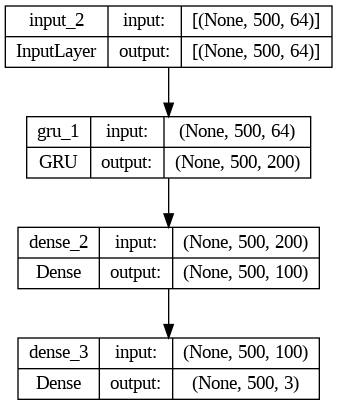

In [15]:
#this will produce a digram of the model
plot_model(training_model, to_file='training_model_arch.png', show_shapes=True, show_layer_names=True)

#### Train the Model on the Training Dataset

In [16]:
# fit the model to the data
results = training_model.fit(X_train, y_train, batch_size=128, epochs=100,
                            validation_split=0.2, shuffle = True, sample_weight=class_weights)

Epoch 1/100
5/5 [==============================] - 13s 2s/step - loss: 1.8820 - accuracy: 0.4393 - val_loss: 1.4601 - val_accuracy: 0.5731
Epoch 2/100
5/5 [==============================] - 9s 2s/step - loss: 1.3344 - accuracy: 0.6169 - val_loss: 1.1771 - val_accuracy: 0.7624
Epoch 3/100
5/5 [==============================] - 8s 2s/step - loss: 1.0358 - accuracy: 0.8065 - val_loss: 0.8505 - val_accuracy: 0.7890
Epoch 4/100
5/5 [==============================] - 9s 2s/step - loss: 0.7954 - accuracy: 0.7624 - val_loss: 0.6760 - val_accuracy: 0.8103
Epoch 5/100
5/5 [==============================] - 10s 2s/step - loss: 0.5837 - accuracy: 0.8374 - val_loss: 0.5725 - val_accuracy: 0.8769
Epoch 6/100
5/5 [==============================] - 8s 2s/step - loss: 0.4678 - accuracy: 0.8988 - val_loss: 0.4193 - val_accuracy: 0.8777
Epoch 7/100
5/5 [==============================] - 9s 2s/step - loss: 0.3736 - accuracy: 0.8658 - val_loss: 0.3487 - val_accuracy: 0.9065
Epoch 8/100
5/5 [===============

#### Visualize the Learning Curves

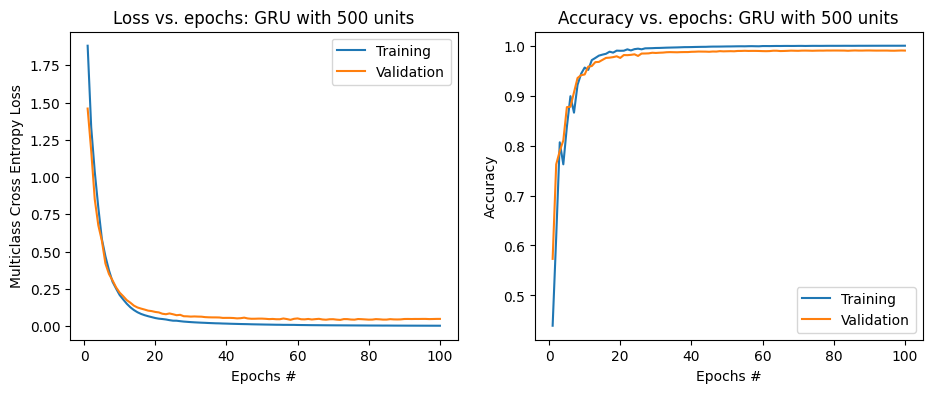

In [19]:
# plot our learning curves
loss = results.history['loss']
val_loss = results.history['val_loss']
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
epochs = np.arange(len(loss))+1

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.xlabel('Epochs #')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.title('Loss vs. epochs: GRU with 500 units')
plt.legend()
plt.savefig('Loss.png', dpi=256)

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.xlabel('Epochs #')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. epochs: GRU with 500 units')
plt.legend()
plt.savefig('Accuracy.png', dpi=256)



training_model.save_weights('weights.hdf5', overwrite=True)



## <a id="2"><u>Stream and Test the Model on the Test Set</u></a>

In this part, we load the training model weights from weights.hd5 file obtained in the training. The resulting model in this code is saved as stream_RNN.hdf5. With setting the batch_shape to `(1, None, 64)`, I set up two streaming modes. The first streaming mode flag is `demo` that is used to print the probability output for classes predicted by the streaming model and also the true one-hot true label at each sequence (s from N_sequence) and instant (n from 500 – as the sequence length). The other mode is `pred_acc`, which is used to return the prediction accuracy of the streaming model for the unseen test set. Below is shown an example of `Demo` for a few instants and also `pred_acc` for the entire test set:

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(1, None, 64)]           0         
                                                                 
 gru_2 (GRU)                 (1, None, 200)            159600    
                                                                 
 dense_4 (Dense)             (1, None, 100)            20100     
                                                                 
 dense_5 (Dense)             (1, None, 3)              303       
                                                                 
Total params: 180,003
Trainable params: 180,003
Non-trainable params: 0
_________________________________________________________________


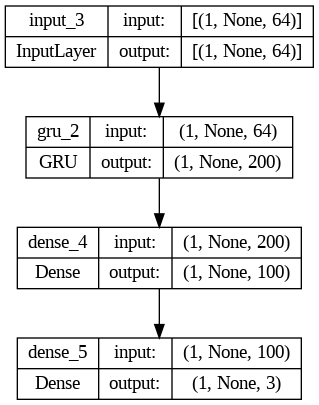

In [20]:
# Demo flag: set to True to see the probability prediction vs the true labels for each instant in sequences
Demo_flag = True

# Pred_acc flag: set to True to compute the accuracy of the streaming model on the unseen test data
Pred_acc_flag = True

test_len = len(y_test)


##### define the streaming-infernece model
streaming_in = Input(batch_shape=(1, None, 64))  ## stateful ==> needs batch_shape specified
foo = GRU(200, return_sequences=True, stateful=True )(streaming_in)
foo = Dense(100, activation='relu')(foo)
streaming_pred = Dense(3, activation='softmax')(foo)
streaming_model = Model(inputs=streaming_in, outputs=streaming_pred)

streaming_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])
streaming_model.summary()


#this will produce a digram of the model
plot_model(streaming_model, to_file='streaming_model_arch.png', show_shapes=True, show_layer_names=True)

In [21]:
##### copy the weights from trained model to streaming-inference model
streaming_model.load_weights('weights.hdf5')
streaming_model.save('Stream_RNN.hdf5')

#### Demo of a few examples using mode `Demo`

In [28]:
##### demo the behaivor
if Demo_flag:
    print('Demo Mode:')
    # for s in range(test_len):
    for s in range(2):
        for n in range(2):
            true_label = y_test[s][n].reshape(1,1,3)

            single_input = X_test[s][n].reshape(1,1,64)
            stream_single_prob = streaming_model.predict(single_input)
            print(f'@ sequence {s}, instant {n}:\n stream_probability= {stream_single_prob}  //  true_label= {true_label}')

        streaming_model.reset_states()

Demo Mode:
1/1 [==============================] - 0s 185ms/step
@ sequence 0, instant 0:
 stream_probability= [[[1.7235778e-01 6.2209764e-04 8.2702011e-01]]]  //  true_label= [[[0. 0. 1.]]]
1/1 [==============================] - 0s 26ms/step
@ sequence 0, instant 1:
 stream_probability= [[[2.1440988e-02 3.3246141e-04 9.7822660e-01]]]  //  true_label= [[[0. 0. 1.]]]
1/1 [==============================] - 0s 24ms/step
@ sequence 1, instant 0:
 stream_probability= [[[9.9712723e-01 2.3503460e-03 5.2239001e-04]]]  //  true_label= [[[1. 0. 0.]]]
1/1 [==============================] - 0s 28ms/step
@ sequence 1, instant 1:
 stream_probability= [[[9.9808383e-01 9.9010416e-04 9.2604139e-04]]]  //  true_label= [[[1. 0. 0.]]]


#### Assess Prediction Accuracy on Test Set via mode `pred_acc`

In [29]:
#### Test accuracy
if Pred_acc_flag:
    stream_pred_correct = 0
    print('Predict Mode:')
    for s in range(test_len):

        pred_compare = np.zeros((1,500))
        true_label = y_test[s].reshape(1,500,3)
        single_input = X_test[s].reshape(1,500,64)
        stream_single_prob = streaming_model.predict(single_input)

        stream_pred_hot = np.argmax(stream_single_prob,axis=2)
        true_label_hot = np.argmax(true_label,axis=2)
        # single_pred = streaming_model.predict(in_feature_vector)[0][0]
        pred_compare[stream_pred_hot==true_label_hot]=1

        stream_pred_correct += np.sum(pred_compare)
        # print(f'Seq-model Prediction, Streaming-Model Prediction, difference [{n}]: {seq_pred[n] : 3.2f}, {single_pred : 3.2f}, {seq_pred[n] - single_pred: 3.2f}')
        streaming_model.reset_states()

        if np.mod(s,100)==0:
            print(f'{round(100*stream_pred_correct/((s+1)*500),2)}% prediction accuracy for {s} sequences')

    stream_pred_acc = stream_pred_correct/(test_len*500)
    print(f'\nThe streaming model prediction accuracy on the entire test set is:  {round(100*stream_pred_acc,2)}%')


Predict Mode:
1/1 [==============================] - 0s 54ms/step
100.0% prediction accuracy for 0 sequences
1/1 [==============================] - 0s 315ms/step

The streaming model prediction accuracy on the entire test set is:  99.1%


As can be seen above, using the GRUs, we have been able to produce a prediction accuracy of `99,1%` on the test set.